In [1]:
import tensorflow as tf
import keras
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, ZeroPadding2D
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
#------------------------------
#cpu - gpu configuration
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) 
keras.backend.set_session(sess)
#------------------------------
#variables
height = 48
width = 48
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 64
epochs = 1000
#------------------------------
#read kaggle facial expression recognition challenge dataset (fer2013.csv)
#https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

with open("../images/fer2013/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

#------------------------------
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print("",end="")

#------------------------------
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train = x_train.reshape(x_train.shape[0], width, height, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], width, height, 1)
x_test = x_test.astype('float32')

q = x_train[...,::-1,:]
x_train = np.concatenate((x_train, q))
y_train = np.concatenate((y_train, y_train))

train_mean = np.mean(x_train)
train_std = np.std(x_train)
test_mean = np.mean(x_test)
test_std = np.std(x_test)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

/home/connor/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


number of instances:  35888
instance length:  2304
57418 train samples
3589 test samples


In [2]:
from imutils import face_utils
import dlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
import skimage
from skimage import img_as_ubyte

def get_patch(c, size):
    top = 0 if c[1]-8 < 0 else c[1]-8
    bot = 47 if c[1]+8 > 47 else c[1]+8
    lef = 0 if c[0]-2 < 0 else c[0]-2
    rig = 47 if c[0]+size-2 > 47 else c[0]+size-2
    return top,bot,lef,rig

def noisy(noise_typ,image,d):
    
    if not d:
        d = {"mouth": np.array([16,38]), "both": np.array([11,18])}
        
    feature = random.choice([0,1])
    #if feature == 0:
    #    top,bot,lef,rig = get_patch(d["both"],40)
    #elif feature == 1:
    top,bot,lef,rig = get_patch(d["mouth"],25)
    modded = image.copy()
    row,col,ch = modded.shape
    if noise_typ == "s&p":
        noise = skimage.util.random_noise(modded,mode=noise_typ, amount = 1)
    else:
        noise = skimage.util.random_noise(modded,mode=noise_typ)
    modded[top:bot,lef:rig] = img_as_ubyte(noise[top:bot,lef:rig])
    return (modded.reshape(dim,dim,1))


dim = 48
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)
W = np.squeeze(x_train, axis=3)
p=0
for x in range(len(W)):
    gray = W[x].astype('uint8')
    rects = detector(gray, 1)
    features = {}
    # For each detected face, find the landmark.
    for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        left_eye = shape[36]
        right_eye = shape[42]
        mouth = shape[48]
        features = {"mouth": mouth, "both":left_eye}


    gray = cv2.resize(gray, (dim,dim))
    gray = np.array(gray)
    gray = gray.reshape(dim, dim, 1)
    img = noisy("s&p",gray,features).astype('float32')
    x_train[x] = img

x_train -= train_mean
x_test -= test_mean
x_train /= train_std 
x_test /= test_std

/home/connor/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [3]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))


gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
valid_generator = val_gen.flow(x_test, y_test, batch_size=batch_size)

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),#SGD(lr = 0.01, momentum=0.9),
              metrics=['accuracy'])

model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=3, verbose=1)

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

checkpointer = ModelCheckpoint('../models/MODEL_Turkey6_occ_train_mouth.h5', monitor='val_acc', verbose=1, save_best_only=True)

tensorboard = TensorBoard(log_dir='../logs/Turkey6_occ_train')

steps_train = train_generator.n//train_generator.batch_size
steps_valid = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(train_generator, 
                                  steps_per_epoch=steps_train, 
                                  validation_steps = steps_valid,
                                  epochs=epochs, 
                                  validation_data=valid_generator,
                                  callbacks=[early_stopper, checkpointer, tensorboard])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
__________

897/897 [==============================] - 82s 91ms/step - loss: 0.9239 - acc: 0.6589 - val_loss: 1.2590 - val_acc: 0.5608

Epoch 00058: val_acc did not improve from 0.58638
Epoch 59/1000
897/897 [==============================] - 82s 91ms/step - loss: 0.9233 - acc: 0.6596 - val_loss: 1.3112 - val_acc: 0.5626

Epoch 00059: val_acc did not improve from 0.58638
Epoch 60/1000
897/897 [==============================] - 80s 89ms/step - loss: 0.8937 - acc: 0.6704 - val_loss: 1.3036 - val_acc: 0.5617

Epoch 00060: val_acc did not improve from 0.58638
Epoch 61/1000
897/897 [==============================] - 81s 90ms/step - loss: 0.8774 - acc: 0.6772 - val_loss: 1.2922 - val_acc: 0.5654

Epoch 00061: val_acc did not improve from 0.58638
Epoch 62/1000
897/897 [==============================] - 82s 91ms/step - loss: 0.8695 - acc: 0.6827 - val_loss: 1.3091 - val_acc: 0.5694

Epoch 00062: val_acc did not improve from 0.58638
Epoch 63/1000
897/897 [==============================] - 80s 89ms/step - l

Text(0.5,1,'Accuracy Curves')

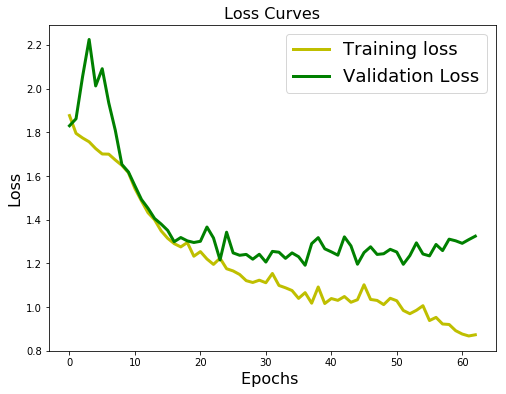

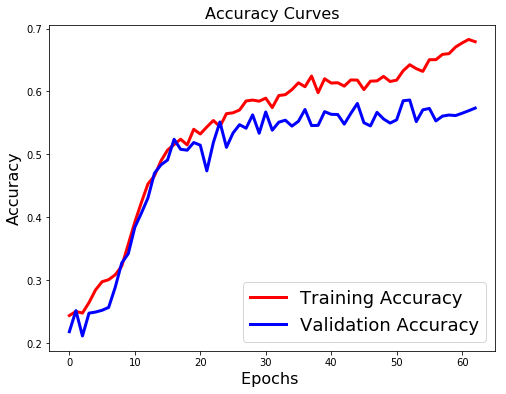

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'y',linewidth=3.0)
plt.plot(history.history['val_loss'],'g',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
# Accuracy curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

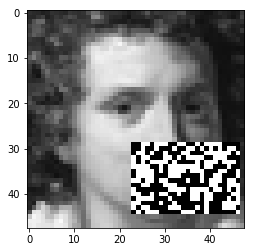

In [8]:
plt.gray()
q = x_train[1000]
q = np.array(q, 'float32')
plt.imshow(q.reshape([48,48]))
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
 
pred_list = []; actual_list = []
p = model.predict(x_test)
for i in p:
    pred_list.append(np.argmax(i))

for i in y_test:
    actual_list.append(np.argmax(i))

confusion_matrix(actual_list, pred_list)

array([[266,   4,  30,  35,  51,  32,  49],
       [ 18,  19,   3,   6,   4,   2,   4],
       [ 67,   5, 147,  25, 102,  86,  64],
       [ 55,   2,  15, 648,  28,  73,  74],
       [107,   2,  43,  45, 292,  40, 124],
       [ 10,   0,  11,  17,  11, 351,  15],
       [ 59,   0,  19,  71,  60,  72, 326]])